Welcome to Voxelmap!

The first thing we'll do is train the neural network (Network A). We'll then test the network to see how it performs. After you've installed all the dependencies in the setup.cfg file, let's do some imports to get started.

In [1]:
# imports
import time
import os
import numpy as np
from matplotlib import pyplot as plt
from utilities import network_a, losses
import torch
from torch.utils.data import Dataset
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

We recommend installing the example data at https://ses.library.usyd.edu.au/handle/2123/32282 and adding the unzipped 'data' folder to your present working directory. We'll then define our image directory as 'data/xcat/train' and define a filename to save our weights and loss plots.

In [2]:
# file name and image directory
im_dir = "/srv/shared/SPARE/MC_V_P1_NS_01"
expt_description = 'Network A_SPARE'
filename = 'train_a_SPARE'

Next we'll create a class called 'SupervisedDataset'. This will allow us to load the appropriate data onto the neural network for training. There are a few idiosyncrasies that we may wish to note. First, all the projection data ends in 'bin.npy' because they were originally created as binary files but were converted to .npy files for convience. The same goes for the volumes and DVFs, which end in 'mha.npy' for similar reasons. The source projection has a '06' in front because, in 4D-CTs the 6 respiratory bin corresponds with the peak-exhale phase. We name our projections 'phase_Proj_num', where phase is respiratory phase (i.e. '01', '02', ... '10') and num is the projection number (e.g. '00001'). For Networks D and E, where we train on the CoMBAT MRI data, the naming convention for slice pairs is 'phase_Slice_xc_ys' where x is the slice number along the coronal axis and y is the slice number along the sagittal axis.

An abdominal mask is used later on in the loss function to force the neural network to optimise predictions within a specific region. The data are then reshaped for the specific dimensions expected for a PyTorch neural network. Right now we are also limited to image sizes that are powers of two (e.g. projections 128x128 and volumes 128x128x128). Everything has been downsampled here to fit on the GPU.

In [9]:
# set up training dataset class
class SupervisedDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        self.im_size = im_size

    def __len__(self):
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])

    def __getitem__(self, idx):
        # Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy')])
        target_file = proj_list[idx]
        proj_name = os.path.join(self.im_dir, format(target_file))
        target_proj = np.load(proj_name)
        target_proj = (target_proj - np.min(target_proj)) / (np.max(target_proj) - np.min(target_proj))

        # Find target DVF
        vol_num = target_file[:2]
        dvf_name = os.path.join(self.im_dir, format('DVF_' + vol_num + '_mha.npy'))
        target_dvf = np.load(dvf_name)

        # Find source projection
        source_file = '06_' + target_file[3:]
        proj_name = os.path.join(self.im_dir, format(source_file))
        source_proj = np.load(proj_name)
        source_proj = (source_proj - np.min(source_proj)) / (np.max(source_proj) - np.min(source_proj))

        # Find source volume
        vol_name = os.path.join(self.im_dir, format('subCT_06_mha.npy'))
        source_vol = np.load(vol_name)
        source_vol = (source_vol - np.min(source_vol)) / (np.max(source_vol) - np.min(source_vol))

        # Find source abdomen
        vol_name = os.path.join(self.im_dir, format('sub_Abdomen_mha.npy'))
        source_hull = np.load(vol_name)

        # Reshape data
        source_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        source_projections[0, :, :] = np.asarray(source_proj)
        target_projections = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
        target_projections[0, :, :] = np.asarray(target_proj)

        source_volumes = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_volumes[0, :, :, :] = np.asarray(source_vol)
        source_abdomen = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        source_abdomen[0, :, :, :] = np.asarray(source_hull)

        target_flow = np.zeros((3, self.im_size, self.im_size, self.im_size), dtype=np.float32)
        target_flow[0, :, :, :] = target_dvf[:, :, :, 0]
        target_flow[1, :, :, :] = target_dvf[:, :, :, 1]
        target_flow[2, :, :, :] = target_dvf[:, :, :, 2]

        data = {'source_projections': torch.from_numpy(source_projections),
                'target_projections': torch.from_numpy(target_projections),
                'source_volumes': torch.from_numpy(source_volumes),
                'source_abdomen': torch.from_numpy(source_abdomen),
                'target_flow': torch.from_numpy(target_flow)}
        
        return data

Let's visualise a projection, a volume and a DVF to make sure our dataloader is working properly.

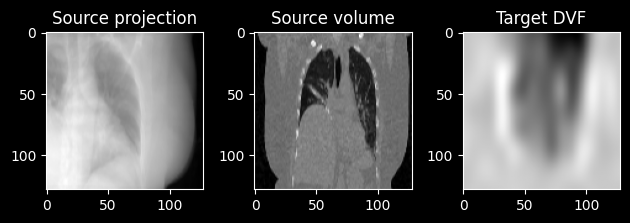

In [12]:
# Generate test loader
batch_size = 1
im_size = 128
exampleset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
exampleloader = torch.utils.data.DataLoader(exampleset, batch_size=batch_size)
data = next(iter(exampleloader))

source_proj, target_proj, source_vol, source_abdomen, target_flow = data['source_projections'], \
                                                                                        data['target_projections'], \
                                                                                        data['source_volumes'], \
                                                                                        data['source_abdomen'], \
                                                                                        data['target_flow']
# visualise projection, volume and DVF
f = plt.figure()
plt.subplot(1,3,1)
source_proj = np.squeeze(source_proj)
plt.imshow(source_proj, cmap='gray')
plt.title('Source projection')

plt.subplot(1,3,2)
source_vol = np.squeeze(source_vol)
plt.imshow(np.transpose(source_vol[:,:, int(source_vol.shape[2] / 2)]), cmap='gray')
plt.title('Source volume')

plt.subplot(1,3,3)
target_flow = np.squeeze(target_flow)
plt.imshow(np.flipud(np.transpose(target_flow[1,:,:, int(source_vol.shape[2] / 2)])), cmap='gray')
plt.title('Target DVF')

f.tight_layout()
plt.show()

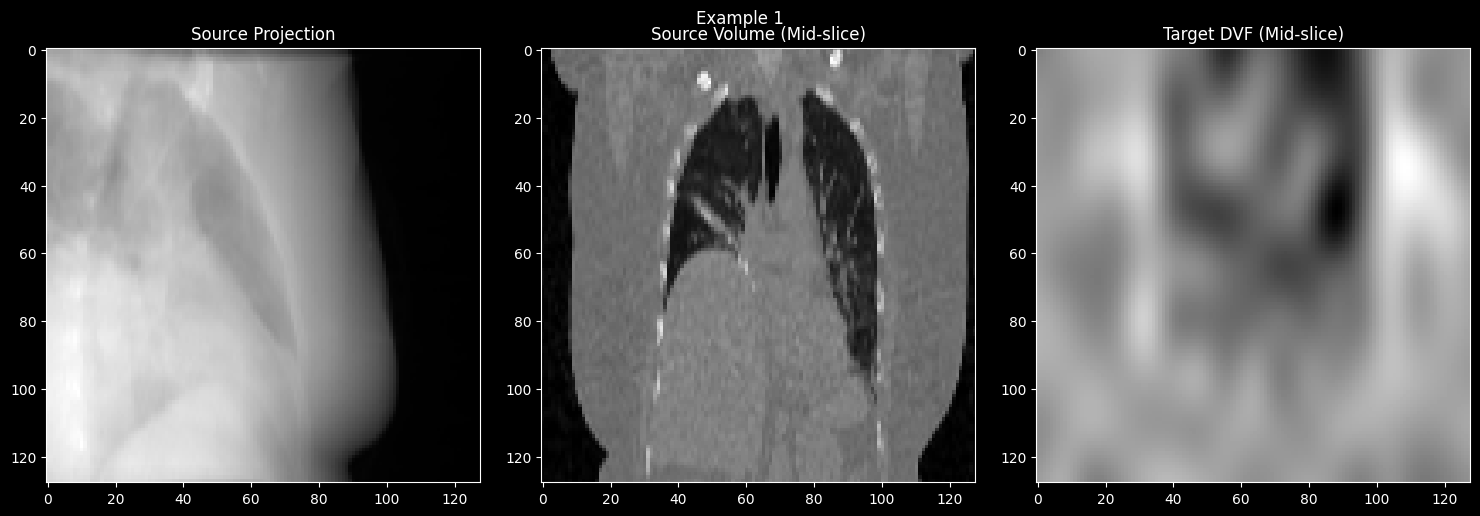

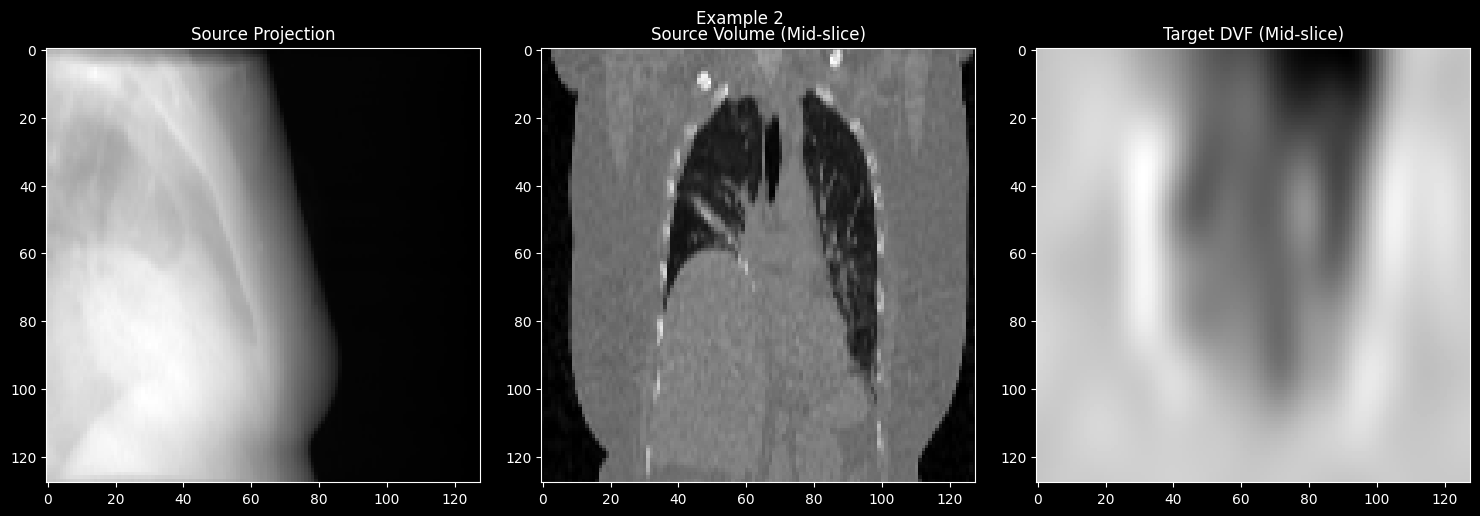

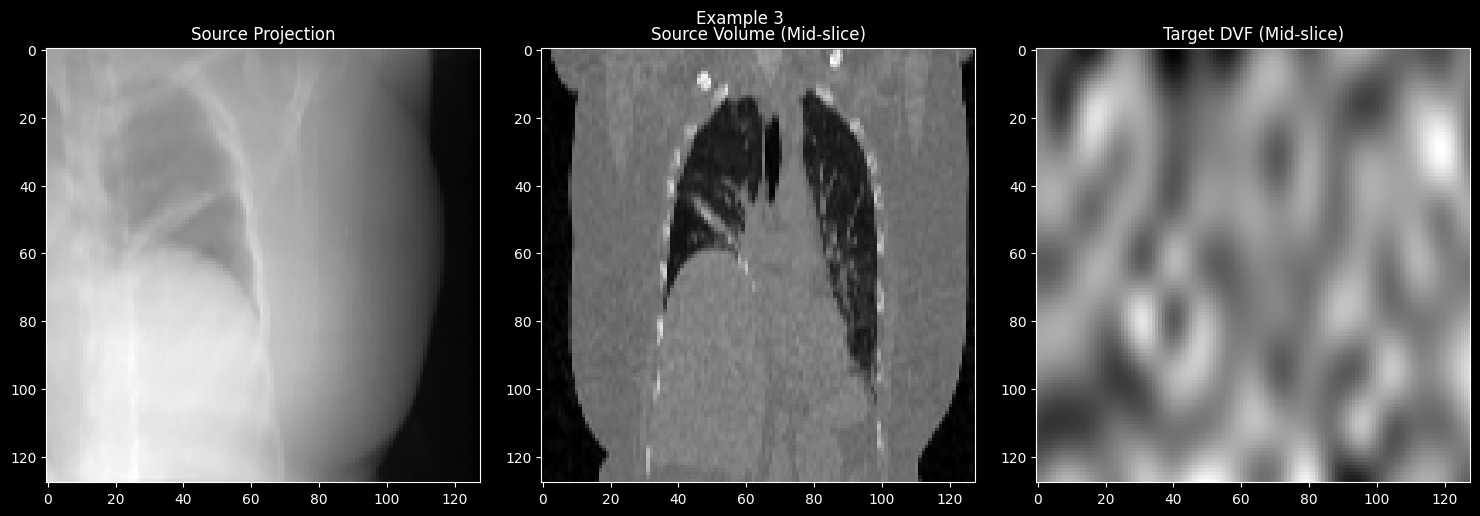

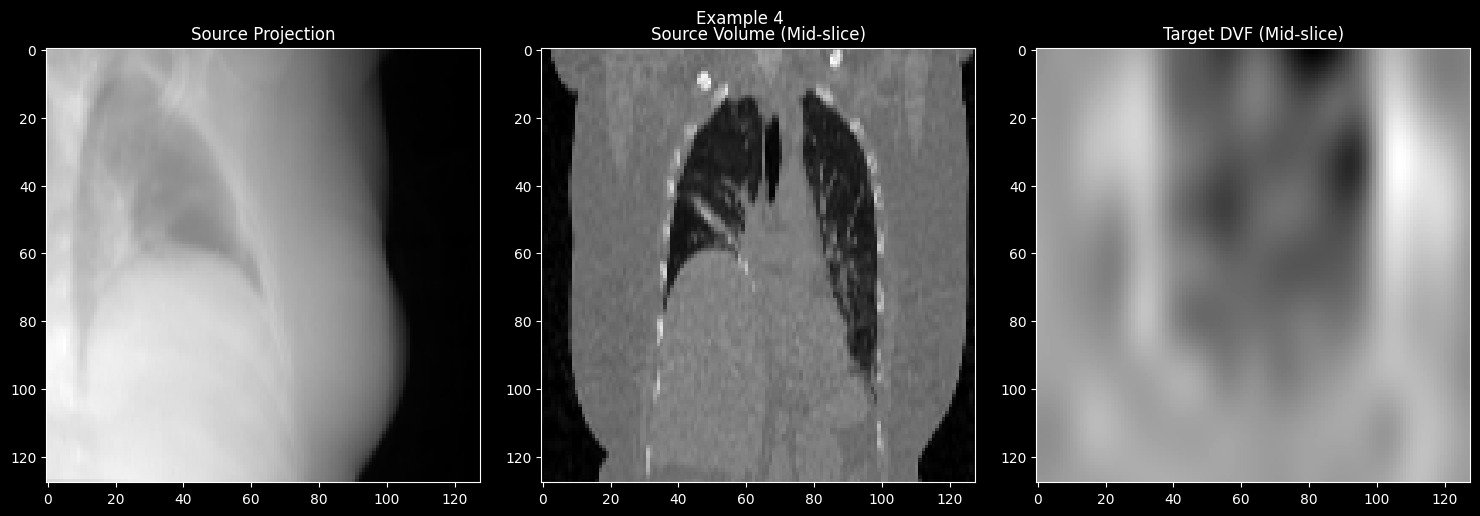

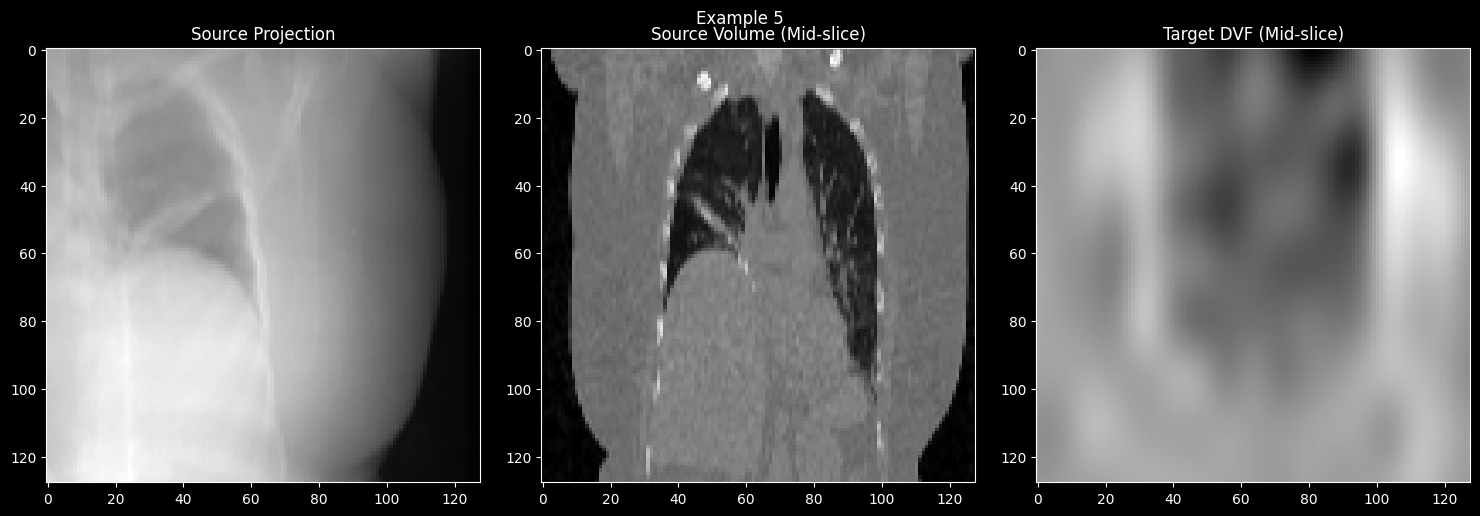

In [13]:
# 2. Generate test loader and visualize 5 examples
batch_size = 1
im_size = 128
exampleset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
exampleloader = torch.utils.data.DataLoader(exampleset, batch_size=batch_size, shuffle=True)

# Iterate and plot 5 examples
for i in range(5):
    data = next(iter(exampleloader))
    source_p = np.squeeze(data['source_projections'].numpy())
    source_v = np.squeeze(data['source_volumes'].numpy())
    t_flow = np.squeeze(data['target_flow'].numpy())

    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(f"Example {i+1}")

    # Plot Source Projection
    plt.subplot(1, 3, 1)
    plt.imshow(source_p, cmap='gray')
    plt.title('Source Projection')

    # Plot Central Slice of Source Volume
    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(source_v[:, :, int(source_v.shape[2] / 2)]), cmap='gray')
    plt.title('Source Volume (Mid-slice)')

    # Plot Central Slice of Target DVF
    plt.subplot(1, 3, 3)
    plt.imshow(np.flipud(np.transpose(t_flow[1, :, :, int(source_v.shape[2] / 2)])), cmap='gray')
    plt.title('Target DVF (Mid-slice)')

    plt.tight_layout()
    plt.show()

Lookin' good! Now we will create training and validation datasets

In [14]:
# generate train/test split
im_size = 128
batch_size = 8
dataset = SupervisedDataset(im_dir=im_dir, im_size=im_size)
split = [int(len(dataset) * 0.9), int(len(dataset) * 0.1)]
trainset, valset = torch.utils.data.dataset.random_split(dataset, split)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

Network time! Let's set up a cuda implementation of the network, a loss function (good ol' MSE will do! but we're computing it within a thoracoabdominal mask) and an optimizer

In [15]:
# set up network
model = network_a.model(im_size, int_steps=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# set loss function and optimizer
flow_mask = losses.flow_mask()
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

Are you ready? Next thing to do is to train the network :) We'll save the weights and a plot of the loss curves. We recommend training for 50 epochs. (Using a NVIDIA RTX A6000, this will take 6-8 hours, so we may need to come back tomorrow.)

Training (on cuda:0)...
Epoch: 1 | train loss: 0.1423 | val loss: 0.0396 | total time: 0 hours 14 minutes
Epoch: 2 | train loss: 0.1048 | val loss: 0.0624 | total time: 0 hours 29 minutes
Epoch: 3 | train loss: 0.0836 | val loss: 0.0517 | total time: 0 hours 44 minutes
Epoch: 4 | train loss: 0.0688 | val loss: 0.0276 | total time: 1 hours 0 minutes
Epoch: 5 | train loss: 0.0579 | val loss: 0.0269 | total time: 1 hours 15 minutes
Finished training


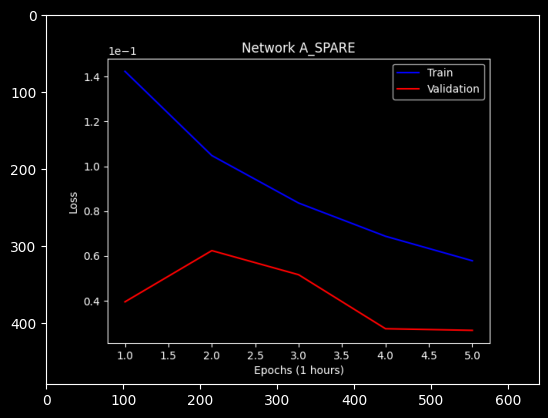

In [17]:
# train
print('Training (on ' + str(device) + ')...')
tic = time.time()
min_val_loss = float('inf')
train_losses, val_losses = [], []
epoch_num = 5

for epoch in range(1, epoch_num + 1):
    train_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        source_proj, target_proj, source_vol, source_abdomen, target_flow = data['source_projections'].to(device), \
                                                                            data['target_projections'].to(device), \
                                                                            data['source_volumes'].to(device), \
                                                                            data['source_abdomen'].to(device), \
                                                                            data['target_flow'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        _, predict_flow = model.forward(source_proj, target_proj, source_vol)
        loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # test and print every epoch
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for j, valdata in enumerate(valloader, 0):
            source_proj, target_proj, source_vol, source_abdomen, target_flow = data['source_projections'].to(device), \
                                                                                data['target_projections'].to(device), \
                                                                                data['source_volumes'].to(device), \
                                                                                data['source_abdomen'].to(device), \
                                                                                data['target_flow'].to(device)

            _, predict_flow = model.forward(source_proj, target_proj, source_vol)
            loss = flow_mask.loss(target_flow, predict_flow, source_abdomen)
            val_loss += loss.item()

    toc = time.time()
    time_elapsed = (toc - tic) / 3600
    hours = np.floor(time_elapsed)
    minutes = (time_elapsed - hours) * 60

    print('Epoch: %d | train loss: %.4f | val loss: %.4f | total time: %d hours %d minutes' %
          (epoch, train_loss / len(trainset), val_loss / len(valset), hours, minutes))
    train_losses.append(train_loss / len(trainset))
    val_losses.append(val_loss / len(valset))

    # save model with lowest validation cost
    if val_loss < min_val_loss:
        if not os.path.exists('weights'):
            os.mkdir('weights')
        PATH = 'weights/' + filename + '.pth'
        torch.save(model.state_dict(), PATH)
        min_val_loss = val_loss

    # plot training
    plt.figure()
    plt.title(expt_description)
    plt.plot(np.array(range(1, epoch + 1)), np.array(train_losses), 'b')
    plt.plot(np.array(range(1, epoch + 1)), np.array(val_losses), 'r')
    plt.legend(['Train', 'Validation'])
    plt.ylabel('Loss')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    if minutes > 30:
        hours += 1
    plt.xlabel('Epochs' + ' (' + str(int(hours)) + ' hours)')
    if not os.path.exists('plots'):
        os.mkdir('plots')
    plt.savefig('plots/' + filename + '.png')
    plt.close()

print('Finished training')
torch.cuda.empty_cache()

plt.imshow(plt.imread('plots/' + filename + '.png'))
plt.show()

That was an exciting moment...we now have a trained neural network. Last thing to do is test it! First, let's point to the weights we want and the directory for our unseen test data.

In [18]:
# file names
expt_file = 'train_a_SPARE'
test_file = '/srv/shared/SPARE/MC_V_P1_SC_02'

Just as we did for training, we will create a new class that allows us to load our test data. This class looks a lot more involved because we have lots and lots of things to test: target overlap, OAR overlap, image similarity...

In [53]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class validateSPAREDataset(Dataset):
    def __init__(self, im_dir=None, im_size=None):
        self.im_dir = im_dir
        # Source files (Phase 06) and global contours are in the 'source' subfolder
        self.ref_dir = os.path.join(im_dir, 'source')
        self.im_size = im_size

    def __len__(self):
        # Count target projections (excluding phase 06 reference files)
        return len([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])

    def __getitem__(self, idx):
        # 1. Find target projection
        proj_list = sorted([n for n in os.listdir(self.im_dir) if n.endswith('_bin.npy') and not n.startswith('06_')])
        target_file = proj_list[idx]
        target_proj = np.load(os.path.join(self.im_dir, target_file))

        # 2. Find target volume using RespBin.csv logic
        resp_bin_path = os.path.join(self.im_dir, 'RespBin.csv')
        resp_bins = np.genfromtxt(resp_bin_path)
        bin_val = int(resp_bins[idx])

        # Format the volume number (e.g., 1 -> '01', 10 -> '10')
        if bin_val < 10:
            vol_num = '0' + str(bin_val)
        else:
            vol_num = str(bin_val) # Assuming 10 is the max, else use str(bin_val)

        # Load the volume corresponding to the bin index
        target_vol = np.load(os.path.join(self.im_dir, f'subCT_{vol_num}_mha.npy'))

        # 3. Find source data (Reference Phase 06) from the 'source' folder
        # Reconstructs source filename (e.g., 01_Proj_001.npy -> 06_Proj_001.npy)
        source_proj_name = '06_'+"Proj_" + '_'.join(target_file.split('_')[1:])
        source_proj = np.load(os.path.join(self.ref_dir, source_proj_name))

        source_vol = np.load(os.path.join(self.im_dir, 'subCT_06_mha.npy'))

        # 4. Find restricted contours (Lung and PTV only) from 'source' folder
        source_lung = np.load(os.path.join(self.ref_dir, 'itv_Lung_mha.npy'))
        source_ptv = np.load(os.path.join(self.ref_dir, 'itv_PTV_mha.npy'))

        # 5. Load Angle
        angle_data = np.genfromtxt(os.path.join(self.im_dir, 'Angles.csv'))
        angle = angle_data[idx]

        # 6. Reshape and convert to Tensors
        def to_tensor(data, is_vol=True):
            if is_vol:
                out = np.zeros((1, self.im_size, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            else:
                out = np.zeros((1, self.im_size, self.im_size), dtype=np.float32)
                out[0, ...] = np.asarray(data)
            return torch.from_numpy(out)

        data = {
            'source_projections': to_tensor(source_proj, is_vol=False),
            'target_projections': to_tensor(target_proj, is_vol=False),
            'source_volumes': to_tensor(source_vol),
            'source_lung': to_tensor(source_lung),
            'source_ptv': to_tensor(source_ptv),
            'target_volumes': to_tensor(target_vol),
            'angle': angle
        }

        return data

Let's instantiate the validation dataset class, set up a cuda implementation, and load the pre-trained weights of our network. We'll also print the number of trainable parameters for our records.

In [54]:
# Generate test loader
batch_size = 1
im_size = 128
#dataset = validateSPAREDataset(im_dir=test_file, ref_dir=test_file + '/source', im_size=im_size)
# The class now handles the '/source' path internally
dataset = validateSPAREDataset(im_dir=test_file, im_size=im_size)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Import network and set up cuda implementation
#model = network_a.VxmDense(im_size, int_steps=10)
model = network_a.model(im_size, int_steps=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
PATH = 'weights/' + expt_file + '.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

print('Number of paramters: %d' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))

Number of paramters: 10836973


Next we'll load a spatial transformation module. This will allow us to take in a predicted DVF and use it to warp reference images and volumes.

In [55]:
# Load transformer
from utilities import spatialTransform
transformer = spatialTransform.Network([im_size, im_size, im_size])
transformer.to(device)

Network(
  (transformer): SpatialTransformer()
)

Let's load up some loss functions. Here we'll look at the difference in centroid positions, Dice similarity to the target and OAR contours, the Jacobian determinant of predicted DVFs as well as the structural similarity and peak signal-to-noise ratio of the predicted images (courtesy of the skimage.metrics library). We'll also create some empty lists to save these metrics

In [80]:
# loss functions
centroid_ptv = losses.centroid_ptv()
dice = losses.dice()
jacobian_determinant = losses.jacobian_determinant()
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Initialise Target (PTV) tracking metrics
# These remain the same as they track the 3D offset in mm
tar_lr, tar_si, tar_ap = [], [], [] # Ground-truth (if available)
pred_lr, pred_si, pred_ap = [], [], [] # Predicted tracking
test_angles = []

# Initialise Geometry/Regularity metrics
test_dice = []  # To be used if you add target_ptv to your dataset
test_detJ = []  # Jacobian determinant for flow regularity

# Updated OAR tracking metrics (Lung only now)
# Since you are using itv_Lung_mha.npy, we use a single lung metric list
lung_dice = []

# Initialise Image Quality metrics
# These track how well the warped source_vol matches target_vol
test_mse, test_ssim, test_psnr = [], [], []



Ok, let's iterate over our unseen test data, recording all the metrics we want. (It may take a couple of minutes to run through all our examples)

In [75]:
print('Testing...')
for i, data in enumerate(testloader, 0):
    # Unpack only what is provided by the new validateSPAREDataset
    source_proj = data['source_projections'].to(device)
    target_proj = data['target_projections'].to(device)
    source_vol  = data['source_volumes'].to(device)
    source_lung = data['source_lung'].to(device) # itv_Lung_mha.npy
    source_ptv  = data['source_ptv'].to(device)  # itv_PTV_mha.npy
    target_vol  = data['target_volumes'].to(device)
    angle       = data['angle'].to(device)

    # 1. Forward pass: Predict PTV deformation and Flow Field
    # Note: predict_ptv is the source_ptv warped by the predicted flow
    predict_ptv, predict_flow = model.forward(source_proj, target_proj, source_ptv)

    # 2. Centroid tracking for predicted PTV
    lr, si, ap = centroid_ptv.loss(predict_ptv)

    # Convert to mm (based on your subsampling factors)
    lr = 4 * lr
    si = 2 * si
    ap = 4 * ap

    pred_lr.append(lr)
    pred_si.append(si)
    pred_ap.append(ap)

# Convert to mm (based on your subsampling factors)
    lr = 4 * lr
    si = 2 * si
    ap = 4 * ap

    tar_lr.append(lr)
    tar_si.append(si)
    tar_ap.append(ap)

    # 3. Compute and save Jacobian violation ratio (Regularity check)
    disp = np.zeros((im_size, im_size, im_size, 3), dtype=np.float32)
    metric_flows = np.squeeze(predict_flow.detach().cpu().numpy())
    disp[:, :, :, 0] = metric_flows[0, :, :, :]
    disp[:, :, :, 1] = metric_flows[1, :, :, :]
    disp[:, :, :, 2] = metric_flows[2, :, :, :]

    detJ = jacobian_determinant.loss(disp)
    detJ_ratio = sum(j <= 0 for j in detJ.flatten()) / detJ.size
    test_detJ.append(detJ_ratio)

    # 4. Save gantry angle
    test_angles.append(angle.item())

    # 5. Warp volumes and calculate Image Quality metrics
    predict_vol = transformer.forward(source_vol, predict_flow)

    # Detach and flatten for numpy-based metrics
    metric_input = target_vol.cpu().detach().numpy().flatten()
    metric_pred = predict_vol.cpu().detach().numpy().flatten()

    # Calculate MSE, SSIM, and PSNR
    mse_val = np.sqrt(np.mean(np.square((metric_input - metric_pred))))
    ssim_val = ssim(metric_input, metric_pred, data_range=np.max(metric_pred) - np.min(metric_pred))
    psnr_val = psnr(metric_input, metric_pred)

    test_mse.append(mse_val)
    test_ssim.append(ssim_val)
    test_psnr.append(psnr_val)

    # 6. Warp Lung for visualization or future evaluation
    predict_lung = transformer.forward(source_lung, predict_flow)

    if i % 10 == 0:
        print(f"{i} of {len(testloader)}")

Testing...
0 of 680
10 of 680
20 of 680
30 of 680
40 of 680
50 of 680
60 of 680
70 of 680
80 of 680
90 of 680
100 of 680
110 of 680
120 of 680
130 of 680
140 of 680
150 of 680
160 of 680
170 of 680
180 of 680
190 of 680
200 of 680
210 of 680
220 of 680
230 of 680
240 of 680
250 of 680
260 of 680
270 of 680
280 of 680
290 of 680
300 of 680
310 of 680
320 of 680
330 of 680
340 of 680
350 of 680
360 of 680
370 of 680
380 of 680
390 of 680
400 of 680
410 of 680
420 of 680
430 of 680
440 of 680
450 of 680
460 of 680
470 of 680
480 of 680
490 of 680
500 of 680
510 of 680
520 of 680
530 of 680
540 of 680
550 of 680
560 of 680
570 of 680
580 of 680
590 of 680
600 of 680
610 of 680
620 of 680
630 of 680
640 of 680
650 of 680
660 of 680
670 of 680


Let's save the results in a directory called 'plots'

In [76]:
print(len(test_angles),len(tar_lr),len(tar_si),len(tar_ap))

680 680 680 680


In [78]:
# Create experiment directory
if not os.path.exists('plots/' + expt_file):
    os.makedirs('plots/' + expt_file, exist_ok=True)

# 1. Save target tracking metrics (Centroids and Regularity)
np.save('plots/' + expt_file + '/' + 'test_angles.npy', test_angles)
np.save('plots/' + expt_file + '/' + 'tar_lr_mm.npy', tar_lr)
np.save('plots/' + expt_file + '/' + 'tar_si_mm.npy', tar_si)
np.save('plots/' + expt_file + '/' + 'tar_ap_mm.npy', tar_ap)
np.save('plots/' + expt_file + '/' + 'pred_lr_mm.npy', pred_lr)
np.save('plots/' + expt_file + '/' + 'pred_si_mm.npy', pred_si)
np.save('plots/' + expt_file + '/' + 'pred_ap_mm.npy', pred_ap)
np.save('plots/' + expt_file + '/' + 'test_dice.npy', test_dice)  # PTV Dice
np.save('plots/' + expt_file + '/' + 'test_detJ.npy', test_detJ)

# 2. Save OAR metrics (Updated for Lung only)
# We use the lung_dice list that corresponds to your 'itv_Lung_mha.npy'
np.save('plots/' + expt_file + '/' + 'lung_itv_dice.npy', lung_dice)

# 3. Save image quality metrics
np.save('plots/' + expt_file + '/' + 'test_mse.npy', test_mse)
np.save('plots/' + expt_file + '/' + 'test_ssim.npy', test_ssim)
np.save('plots/' + expt_file + '/' + 'test_psnr.npy', test_psnr)

print(f"Metrics successfully saved to plots/{expt_file}/")

Metrics successfully saved to plots/train_a_SPARE/


Lastly, we'll print the results and generate a tracking plot for the centroid positions, et voila! I hope you enjoy using Voxelmap. We have started a Discussion section on the Github repository to hear about your experiences.

--- Global Metrics ---
[3D Error (mm): 987.2 ± 4.6 | Jacobian detJ: 0E+00]
[SSIM: 0.96 ± 0.01 | PSNR: 61.4 ± 0.9]


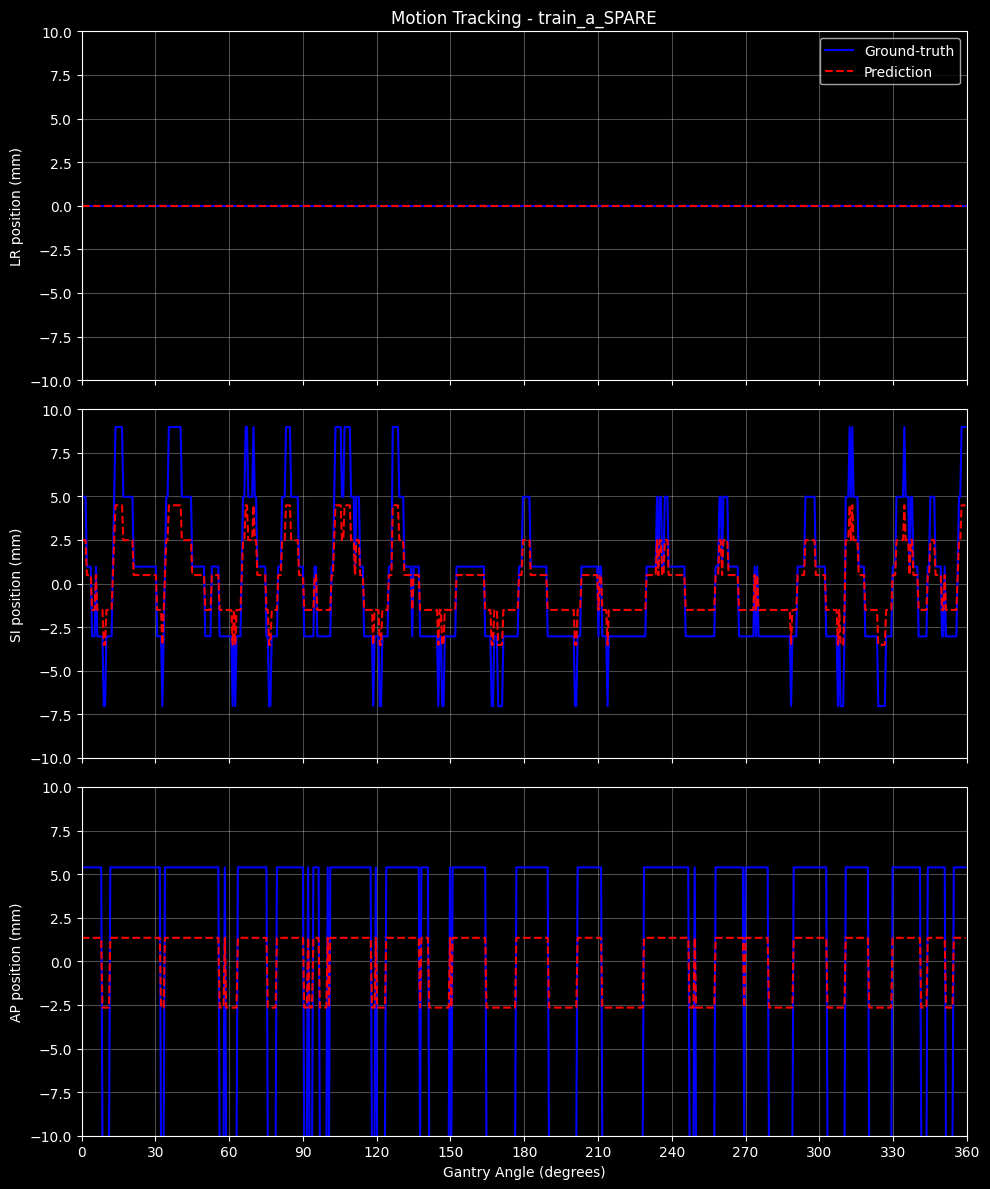

In [79]:
# 1. Print Results
# Calculate 3D Euclidean distance between Ground-Truth and Predicted centroids
dx = np.asarray(tar_lr) - np.asarray(pred_lr)
dy = np.asarray(tar_si) - np.asarray(pred_si)
dz = np.asarray(tar_ap) - np.asarray(pred_ap)
error_3d = np.sqrt(dx**2 + dy**2 + dz**2)

print('--- Global Metrics ---')
# Check if test_dice has content before printing to avoid mean of empty slice errors
if test_dice:
    print('[Target PTV Dice: %.2f ± %.2f]' % (np.mean(test_dice), np.std(test_dice)))

print('[3D Error (mm): %.1f ± %.1f | Jacobian detJ: %.0E]' % (np.mean(error_3d), np.std(error_3d), np.mean(test_detJ)))

# Consolidated OAR Print (Lung Only)
if lung_dice:
    print('[Lung ITV DSC: %.2f ± %.2f]' % (np.mean(lung_dice), np.std(lung_dice)))

print('[SSIM: %.2f ± %.2f | PSNR: %.1f ± %.1f]' % (np.mean(test_ssim), np.std(test_ssim), np.mean(test_psnr), np.std(test_psnr)))

# 2. Plot Centroid Traces
# Zero-center the traces for better comparison of motion amplitude
def prepare_trace(trace, angles):
    trace = np.asarray(trace)
    trace = trace - np.mean(trace)
    return [t for _, t in sorted(zip(angles, trace))]

tar_lr_plot = prepare_trace(tar_lr, test_angles)
tar_si_plot = prepare_trace(tar_si, test_angles)
tar_ap_plot = prepare_trace(tar_ap, test_angles)

pred_lr_plot = prepare_trace(pred_lr, test_angles)
pred_si_plot = prepare_trace(pred_si, test_angles)
pred_ap_plot = prepare_trace(pred_ap, test_angles)

sorted_angles = sorted(test_angles)

# Plotting
f, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
labels = ['LR position (mm)', 'SI position (mm)', 'AP position (mm)']
data_tar = [tar_lr_plot, tar_si_plot, tar_ap_plot]
data_pred = [pred_lr_plot, pred_si_plot, pred_ap_plot]

for idx, ax in enumerate(axes):
    ax.plot(sorted_angles, data_tar[idx], label='Ground-truth', color='blue')
    ax.plot(sorted_angles, data_pred[idx], label='Prediction', color='red', linestyle='--')
    ax.set_ylabel(labels[idx])
    ax.set_ylim([-10, 10]) # Adjusted for typical lung motion range
    ax.set_xlim([0, 360])
    ax.set_xticks(np.arange(0, 361, 30))
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.set_title(f'Motion Tracking - {expt_file}')
        ax.legend(loc='upper right')
    if idx == 2:
        ax.set_xlabel('Gantry Angle (degrees)')



f.tight_layout()
plt.savefig('plots/' + expt_file + '_trace.png')
plt.show()